# Background

In the field of experimental design, D-optimality is a criterion for selecting the most efficient design for a given model and set of experimental conditions. A D-optimal design minimizes the volume of the error ellipsoid or maximizes the Fisher information matrix, which represents the uncertainty in the estimated parameters of the model. D-optimal designs are particularly useful in situations where the model is highly nonlinear, or when there are a large number of parameters to be estimated. They can also be used to identify the most important factors in a model, or to optimize the performance of a system.

In this project, D-optimal design will be applied to optimize the sampling schedule in a PK study, aiming to better understand the concepts involved in optimal design, such as Fisher information matrix and D-optimal criterion, by reproducing part of the [warfarin example](https://andrewhooker.github.io/PopED/articles/handling_LOQ.html) with python. This project is inspired by Prof. Andrew Hooker's *Optimal Design* lecture and [popED](https://github.com/andrewhooker/PopED), a R package computing optimal experimental designs based on nonlinear mixed-effect models. 

# Project Scenario

**PK Model**: one compartment model

**Parameters**:
- KA: absorption constant
- CL: clearance
- V: volume of distribution
- Omega: individual deviation from the parameter typical values ~ MultiNormal(0, Omega2)
- Simga: Observation deviation from the population mean ~ Normal(0, Sigma2)

(The project only focuses on the uncertaninty reduction of KA, CL, V)

**Design**:
- **Administration Route**: Oral
- **Dosage Regimen**: 70 mg, single dose
- **Sampling Schedule**: 0.5, 3, 50, 120 minutes after dosing [**to be optimized**]
- **Subject Numbers**: 35

**Project Goal**: find the most informative sampling schedule, where "informative" means less uncertainty in the parameter estimate

# Libraries

In [93]:
import jax.numpy as jnp
from jax import jacfwd, hessian, random, jit, vmap
from jax.scipy.stats import norm 
from scipy.optimize import minimize, Bounds

import matplotlib.pyplot as plt

# Data Simulation

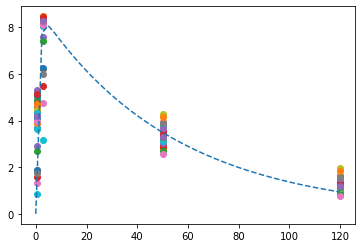

In [115]:
# random seed
param_key, sigma_key = random.split(random.PRNGKey(105))

# PK Model: one compartment model
def forward(DOSE, params, time):
    KA, CL, V = params[0], params[1], params[2]
    return DOSE * KA/(V*(KA-CL/V))* (jnp.exp(-CL/V*time)- jnp.exp(-KA*time))

# Design and Parameters
N = 35
# xt = jnp.array([0.5, 3., 50., 120.])
xt_init = jnp.array([0.5, 3., 50., 120.])
time = jnp.linspace(0, 120, 50)
DOSE = jnp.array([70.])

# KA, CL, V
param_tv = jnp.array([1.0, 0.15, 8.])
omega  = jnp.array([0.6, 0.02, 0.07])
param_dev = random.normal(key=param_key, shape=(N, len(param_tv))) * omega
params = jnp.abs(param_dev + param_tv)
sigma  = jnp.array([0.25])

# Simulation and Visualization
conc = vmap(forward, in_axes=(None, 0, None))(DOSE, params, xt_init) + random.normal(key=sigma_key, shape=xt_init.shape) * sigma

plt.plot(time, forward(DOSE, param_tv, time), ls="--")
for i in range(N):
    plt.scatter(xt_init, conc[i], c=f"C{i}")

# Fisher Information Matrix

In the context of optimal design, the Fisher information matrix (FIM) is a crucial tool for assessing the efficiency of experimental designs. It provides a quantitative measure of how much information a particular design can provide about the unknown parameters of a statistical model.

A D-optimal design maximizes the determinant of the FIM, or the log determinant of the FIM. This ensures that the parameter estimates are as precise as possible, given the constraints of the experimental setup. In this project, we will go with the *log determinant of FIM* and use it as the cost to be optimized (maximized).

To calculate the FIM, we first need to define functions to calculate log-likelihood and Hessian matrix. This is becasue the second derivative of the log-likelihood evaluated at the the maximum likelihood estimates is the observed Fisher Information. 

When the negative log-likelihood is minimized, the returned Hessian is the equivalent of the observed Fisher information matrix whereas in the case that the log-likelihood is maximized, then the negative Hessian is the observed information matrix. 

By the way, the estimated standard error of the maximum likelihood estimates is given by the square root of the diagonal elements of the (observed) FIM.

Let 𝑙(𝜃) be a log-likelihood function.

$${FIM}(\theta)=-\frac{\partial^{2}}{\partial\theta_{i}\partial\theta_{j}}l(\theta),~~~~ 1\leq i, j\leq p$$


$${Hessian}(\theta)=\frac{\partial^{2}}{\partial\theta_{i}\partial\theta_{j}}l(\theta),~~~~ 1\leq i, j\leq p$$


$${SE}(\hat{\theta}_{\mathrm{ML}})=\frac{1}{\sqrt{\mathbf{I}(\hat{\theta}_{\mathrm{ML}})}}$$

Reference: [Basic question about Fisher Information matrix and relationship to Hessian and standard errors](https://stats.stackexchange.com/questions/68080/basic-question-about-fisher-information-matrix-and-relationship-to-hessian-and-s?rq=1)

In [116]:
# define log-likelihood function
@jit 
def LL(DOSE, params, time, conc, sigma):
    mu = forward(DOSE, params, time)
    return jnp.sum(norm.logpdf(conc, loc=mu, scale=sigma))

# calculate fisher information matrix as negative hessian (assuming maximum the log-likelihood)
@jit
def fisher_info_mat(doses, params, time, conc, sigma):
    hess = hessian(LL, argnums=(1))
    hes  = hess(doses, params, time, conc, sigma)
    return -hes

# sum up individual FIM, then det(FIM) [similar to popED]
@jit
def FIM_det(doses, params, time, conc, sigma):
    fim_tot = jnp.sum(vmap(fisher_info_mat, in_axes=(None, 0, None, None, None))(doses, params, time, conc, sigma), axis=0)
    fim_det = jnp.linalg.det(fim_tot)
    return jnp.where(fim_det<=0., 0, fim_det)

# define objective function: maximize log(det(FIM))
@jit
def object_fn(xt, DOSE, params, conc, sigma):
    # log(det(FIM))
    return jnp.log(FIM_det(DOSE, params, xt, conc, sigma))

# define mininum objective function: minimize netagive log(det(FIM)), 
# used as object_fn for scipy.optimize.minimize 
@jit
def min_object_fn(xt, DOSE, params, conc, sigma):
    return -jnp.log(FIM_det(DOSE, params, xt, conc, sigma))


# Initial Design Evaluation

In [117]:
# initial OFV
ofv_init = object_fn(xt_init, DOSE, params, conc, sigma)

# # initial FIM
fim_tot = jnp.sum(vmap(fisher_info_mat, in_axes=(None, 0, None, None, None))(DOSE, params, xt_init, conc, sigma), axis=0)

# initial RSE (relative standard error)
fim_inv = jnp.linalg.inv(fim_tot)
rse_init = jnp.sqrt(jnp.diag(fim_inv)) / param_tv * 100

print(f"""OFV: {ofv_init:.3f}\n
FIM:\n{fim_tot}\n
RSE(%):\n{rse_init}""")

OFV: 39.925

FIM:
[[  828857.2      62263.344   -34460.977]
 [   62263.31  12648524.       37739.27 ]
 [  -34460.98     37739.26     22405.594]]

RSE(%):
[0.11361405 0.1880637  0.08657996]


# Optimizing Sampling Schedule
## scipy.optimize.minimize (bounded optimization available)

In [118]:
xt = jnp.array([0.5, 3., 50., 120.])

res = minimize(min_object_fn, x0 = xt, args=(DOSE, params, conc, sigma), 
         method='Nelder-Mead')
ofv_final = res.fun
xt_final = res.x

print(res.message)
print(f"""OFV:
{-ofv_final:.3f}\n
Optimized Sampling Schedule: 
{res.x}""")

Optimization terminated successfully.
OFV:
41.421

Optimized Sampling Schedule: 
[ 2.8645604  3.61311   44.975986  53.26738  ]


## Gradient Descent

Iter:        0 | FIM: 39.925315856933594 | Update: [  6.531349    3.5494075  49.953865  119.941284 ]
Iter:     1000 | FIM: 41.366790771484375 | Update: [ 2.8836377  3.6469357 42.991207  67.39735  ]
Iter:     2000 | FIM: 41.42048263549805 | Update: [ 2.8677685  3.615566  44.737244  53.96385  ]
Iter:     3000 | FIM: 41.420684814453125 | Update: [ 2.8667734  3.6140058 45.01788   53.25873  ]
Iter:     4000 | FIM: 41.420684814453125 | Update: [ 2.8667438  3.6139576 45.032665  53.231373 ]


Text(0, 0.5, 'OFV')

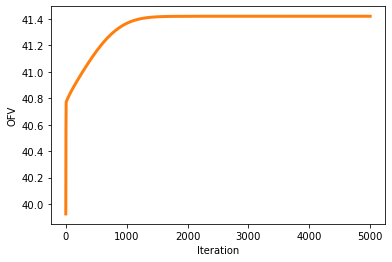

In [119]:
xt = jnp.array([0.5, 3., 50., 120.])
log_FIM_det = []

n_iter = 5000
for i in range(n_iter):
    gd_fn = jacfwd(object_fn, argnums=0)
    gd    = gd_fn(xt, DOSE, params, conc, sigma)
    
    ofv = object_fn(xt, DOSE, params, conc, sigma)
    log_FIM_det.append(ofv)
    
    xt += 5 * gd
    
    if i % (n_iter/5) == 0:
        print(f"Iter: {i:8} | FIM: {ofv} | Update: {xt}")

xt_final = xt

plt.plot(jnp.linspace(0,n_iter,n_iter), log_FIM_det, lw=3, c="C1")
plt.xlabel("Iteration")
plt.ylabel("OFV")

## LM-Algorithm

Iter:     0 | FIM: 39.925315856933594 | Update: [  0.64068604   3.011707    49.99912    119.998825  ]
Iter:   100 | FIM: 40.75824737548828 | Update: [  2.586905    3.4892251  49.900597  119.8803   ]
Iter:   200 | FIM: 40.769874572753906 | Update: [  2.8320193   3.6258445  49.80813   119.761284 ]
Iter:   300 | FIM: 40.772705078125 | Update: [  2.8843684   3.675363   49.718     119.641815 ]
Iter:   400 | FIM: 40.77497863769531 | Update: [  2.8960078   3.6942384  49.629288  119.52203  ]
Iter:   500 | FIM: 40.777183532714844 | Update: [  2.8984115   3.7014558  49.541744  119.40225  ]
Iter:   600 | FIM: 40.779361724853516 | Update: [  2.8987138   3.704097   49.45529   119.28247  ]
Iter:   700 | FIM: 40.781524658203125 | Update: [  2.8985498   3.7049205  49.369892  119.16269  ]
Iter:   800 | FIM: 40.783668518066406 | Update: [  2.8982925   3.7050178  49.28556   119.04291  ]
Iter:   900 | FIM: 40.78579330444336 | Update: [  2.8980165   3.7048268  49.202255  118.92313  ]


Text(0, 0.5, 'OFV')

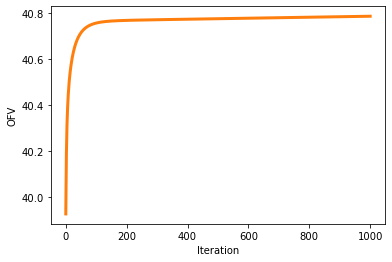

In [122]:
xt = jnp.array([0.5, 3., 50., 120.])
log_FIM_det = []

n_iter = 1000
for i in range(n_iter):
    jacob = jacfwd(object_fn, argnums=0)
    jac   = jacob(xt, DOSE, params, conc, sigma)
    
    hess  = hessian(object_fn, argnums=0)
    hes   = hess(xt, DOSE, params, conc, sigma)
    
    FIM   = object_fn(xt, DOSE, params, conc, sigma)

    log_FIM_det.append(FIM)
    
    xt += jnp.linalg.inv(hes + 10 * jnp.identity(hes.shape[0])) @ jac.T 
    
    if i % (n_iter/10) == 0:
        print(f"Iter: {i:5} | FIM: {FIM} | Update: {xt}")

xt_final = xt

plt.plot(jnp.linspace(0,n_iter,n_iter), log_FIM_det, lw=3, c="C1")
plt.xlabel("Iteration")
plt.ylabel("OFV")

Text(0.5, 1.0, 'Optimized Design')

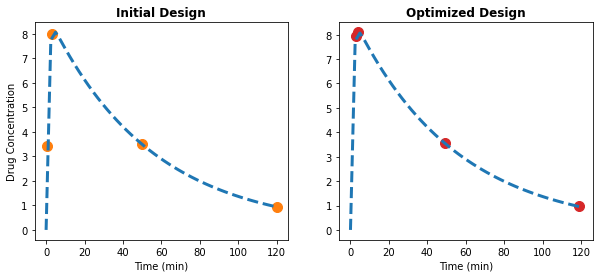

In [131]:
plt.figure(figsize=(10,4))
plt.subplot(121)

plt.plot(time, forward(DOSE, param_tv, time), ls="--", lw=3)
# conc = vmap(forward, in_axes=(None, 0, None))(DOSE, params, xt_init) + random.normal(key=random.PRNGKey(123), shape=xt_init.shape) * sigma
# for i in range(N):
#     plt.scatter(xt_init, conc[i], c=f"C{i}")
plt.scatter(xt_init, forward(DOSE, param_tv, xt_init), c="C1", s=100)
plt.xlabel("Time (min)")
plt.ylabel("Drug Concentration")
plt.title("Initial Design", weight="bold")

plt.subplot(122)
plt.plot(time, forward(DOSE, param_tv, time), ls="--", lw=3)
# conc = vmap(forward, in_axes=(None, 0, None))(DOSE, params, xt_final) + random.normal(key=random.PRNGKey(321), shape=xt_final.shape) * sigma
# for i in range(N):
    # plt.scatter(xt_final, conc[i], c=f"C{i}")
plt.scatter(xt_final, forward(DOSE, param_tv, xt_final), c="C3", s=100)
plt.xlabel("Time (min)")
plt.title("Optimized Design", weight="bold")

In [128]:
# initial Design Evaluation
print("Initial Design Evaluation")

print(f"""OFV: {ofv_init:.3f}\n
FIM (KA | CL | V):\n{fim_tot}\n
RSE (%):\n{rse_init}\n
Initial Sampling Schedule: {xt_init}""")

print("="*30)

# final Design Evaluation
# final OFV and Efficiency [exp(ofv_final) / exp(ofv_init)]**(1/n_params)
ofv_final = object_fn(xt_final, DOSE, params, conc, sigma)
eff = (jnp.exp(ofv_final) / jnp.exp(ofv_init))**(1/5)

# final FIM
fim_tot_final = jnp.sum(vmap(fisher_info_mat, in_axes=(None, 0, None, None, None))(DOSE, params, xt_final, conc, sigma), axis=0)

# final RSE (relative standard error)
fim_inv_final = jnp.linalg.inv(fim_tot_final)
rse_final = jnp.sqrt(jnp.diag(fim_inv_final)) / param_tv * 100

print("Optimized Design Evaluation")
print(f"""
OFV: {ofv_final:.3f}\n
FIM (KA | CL | V):\n{fim_tot_final}\n
RSE (%):\n{rse_final}\n
Optimized Sampling Schedule: {xt_final}\n
Efficiency: {eff:.3f}""")

print("="*30)

Initial Design Evaluation
OFV: 39.925

FIM (KA | CL | V):
[[  828857.2      62263.344   -34460.977]
 [   62263.31  12648524.       37739.27 ]
 [  -34460.98     37739.26     22405.594]]

RSE (%):
[0.11361405 0.1880637  0.08657996]

Initial Sampling Schedule: [  0.5   3.   50.  120. ]
Optimized Design Evaluation

OFV: 40.916

FIM (KA | CL | V):
[[ 1325881.1      33081.996   -34159.133]
 [   33081.938 13040412.       65421.414]
 [  -34159.137    65421.41     35251.945]]

RSE (%):
[0.08797485 0.1855305  0.06775585]

Optimized Sampling Schedule: [  2.8977482   3.7045248  49.12077   118.80454  ]

Efficiency: 1.219
